# Single-Cell Graph Neural Diffusion

In [1]:
# Loading Packages
import func.info_log as info_log
info_log.print('\n> Loading Packages')
import torch
from time import time

# Local modules
import scData.load as load
import scAnalysis.preprocess as preprocess
from GND.graph_DIF import graph_diffusion
from scAnalysis.clustering import kmeans, louvain, leiden, record_cluster, clustering, evaluate_clustering

from scData.scdata_metrics import SCData
from scData.scdata_visualization import umap_view, trajectory_view, similarity_view, diffusion_view, clustering_comparation_view, gnd_view
from scData.scdata_exporting import export_data
from scGraph.build_graph import build_graph, build_gnd_graph
from scGraph.modify_graph import modify_graph
from scGraph.call_attention import call_attention, call_gnd_attention
from scGraph.call_modularity import call_modularity, call_gnd_modularity, view_gnd_modularity
from scAnalysis.build_trajectory import build_trajectory
from func.umap_embedding import umap_embedding, special_umap_embedding, diffusion_umap_embedding, diffusion_ML_embedding

2023-10-17 09:59:44,204 - 
> Loading Packages
2023-10-17 10:00:22.603875: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-17 10:00:25.245182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 10:00:36.467520: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
print(torch.cuda.get_device_name())

cuda
Tesla V100-PCIE-16GB


In [3]:
DATA_PATH = 'data/pbmc3k/filtered_gene_bc_matrices/hg19/'
DATA_TYPE = '10X'
GNN_TYPE = 'gnd'
OUTPUT_PATH = 'outputs/pbmc3k/'

## Loading data and preprocessing 

In [4]:
# Load
info_log.print('\n> Loading data ...')


scdata = load.load_10X_data(DATA_PATH, is_cell_by_gene=True, is_genes=True)


2023-10-17 10:00:56,155 - 
> Loading data ...
2023-10-17 10:00:56,156 - --------> Loading from 10X data ...
2023-10-17 10:00:59,550 - ----------------> Matrix has 2700 cells and 32738 genes


2023-10-17 10:00:59,555 - 
> Preprocessing data ...
2023-10-17 10:00:59,556 - --------> Truncating genes and cells ------- Method: Percentile ...
2023-10-17 10:01:00,676 - --------> Loaded (cell, gene): (2700, 32738), Remove: (0, 16104),Left: (2700, 16634).
2023-10-17 10:01:00,677 - ---------> Log-transforming data ...
2023-10-17 10:01:01,535 - ---------> Sorting and selecting top genes ...


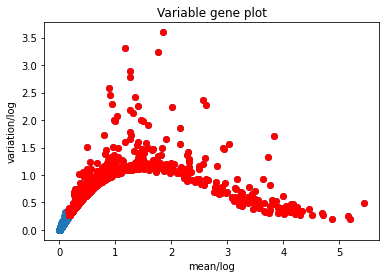

In [5]:
# Preprocessing(pp)
info_log.print('\n> Preprocessing data ...')

# pp method 1
scdata = preprocess.percentile_filter(scdata, cell_cutoff=0, gene_cutoff=10)

#scdata = preprocess.key_filter(scdata, gene_key=None, cell_key=None)

scdata = preprocess.log_transform(scdata, data_type = "raw", log=True, scale=True, scale_factor=10000)

scdata = preprocess.varibale_gene_select(scdata, data_type="raw.log", num_select=2000)

#print(scdata.svg.expr.shape)

## Diffusion process

In [6]:
# Build graph

scdata = build_graph(scdata, k=100, data_type="svg", graph_name='dif_graph', self_edge = False, prune=True)


In [19]:
scdata = graph_diffusion(scdata, D_out=2000, data_type='svg', use_graph='dif_graph', recover_adj_name='dif_graph',
                      max_epoch=2000, lr=5e-4, device=device,
                           num_features_diffusion=50,
                           num_heads_diffusion=6,
                           num_steps_diffusion=8, 
                           time_increment_diffusion=0.5,
                           attention_type = 'sum', 
                           activation=torch.nn.ELU(),
                           dropout=0.0, 
                           log_attention=False, 
                           log_diffusion=True,
                           encoder=None, 
                           decoder=None,
                           save_model = True,
                           load_model_state = False,
                           loss_adj=0.0,
                           rebuild_graph=False,
                           k=100)
scdata.save(OUTPUT_PATH+"scdata.pickle")


2023-10-17 10:13:18,945 - --------> Starting Graph AE ...
/projectnb/czproj/Algorithms/ycliu/scGraphDiffusion/auto_encoders/graph_DIF.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(adj_graph.adj.to(device), dtype = recon_adj.dtype)
/projectnb/czproj/Algorithms/ycliu/scGraphDiffusion/auto_encoders/graph_DIF.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_2 = torch.tensor(feature_matrix.to(device), dtype = out_nodes_features.dtype)
2023-10-17 10:13:19,024 - ------------------------> Epoch: 1/2000, Current loss: 8864190.0000
2023-10-17 10:13:22,593 - ------------------------> Epoch: 51/2000, Current loss: 3319575.0000
2023-10-17 10:13:26,157 - ---

In [6]:
scdata = SCData.load(OUTPUT_PATH+"scdata.pickle")

## Check scdata

In [24]:
# scdata.print_data()

## View UMAP of diffusion data

In [20]:
# Rebuild graph
scdata = build_graph(scdata, k=10, data_type="gae", graph_name='graph', self_edge = False, prune=True)

In [21]:
scdata = umap_embedding(scdata, data = 'gae.output', umap_args = {'n_neighbors': 15,
                                'min_dist': 0.3,
                                'metric': 'correlation',
                                'random_state': 2021})
scdata = umap_embedding(scdata, data = 'gae.input', umap_args = {'n_neighbors': 15,
                                'min_dist': 0.3,
                                'metric': 'correlation',
                                'random_state': 2021})

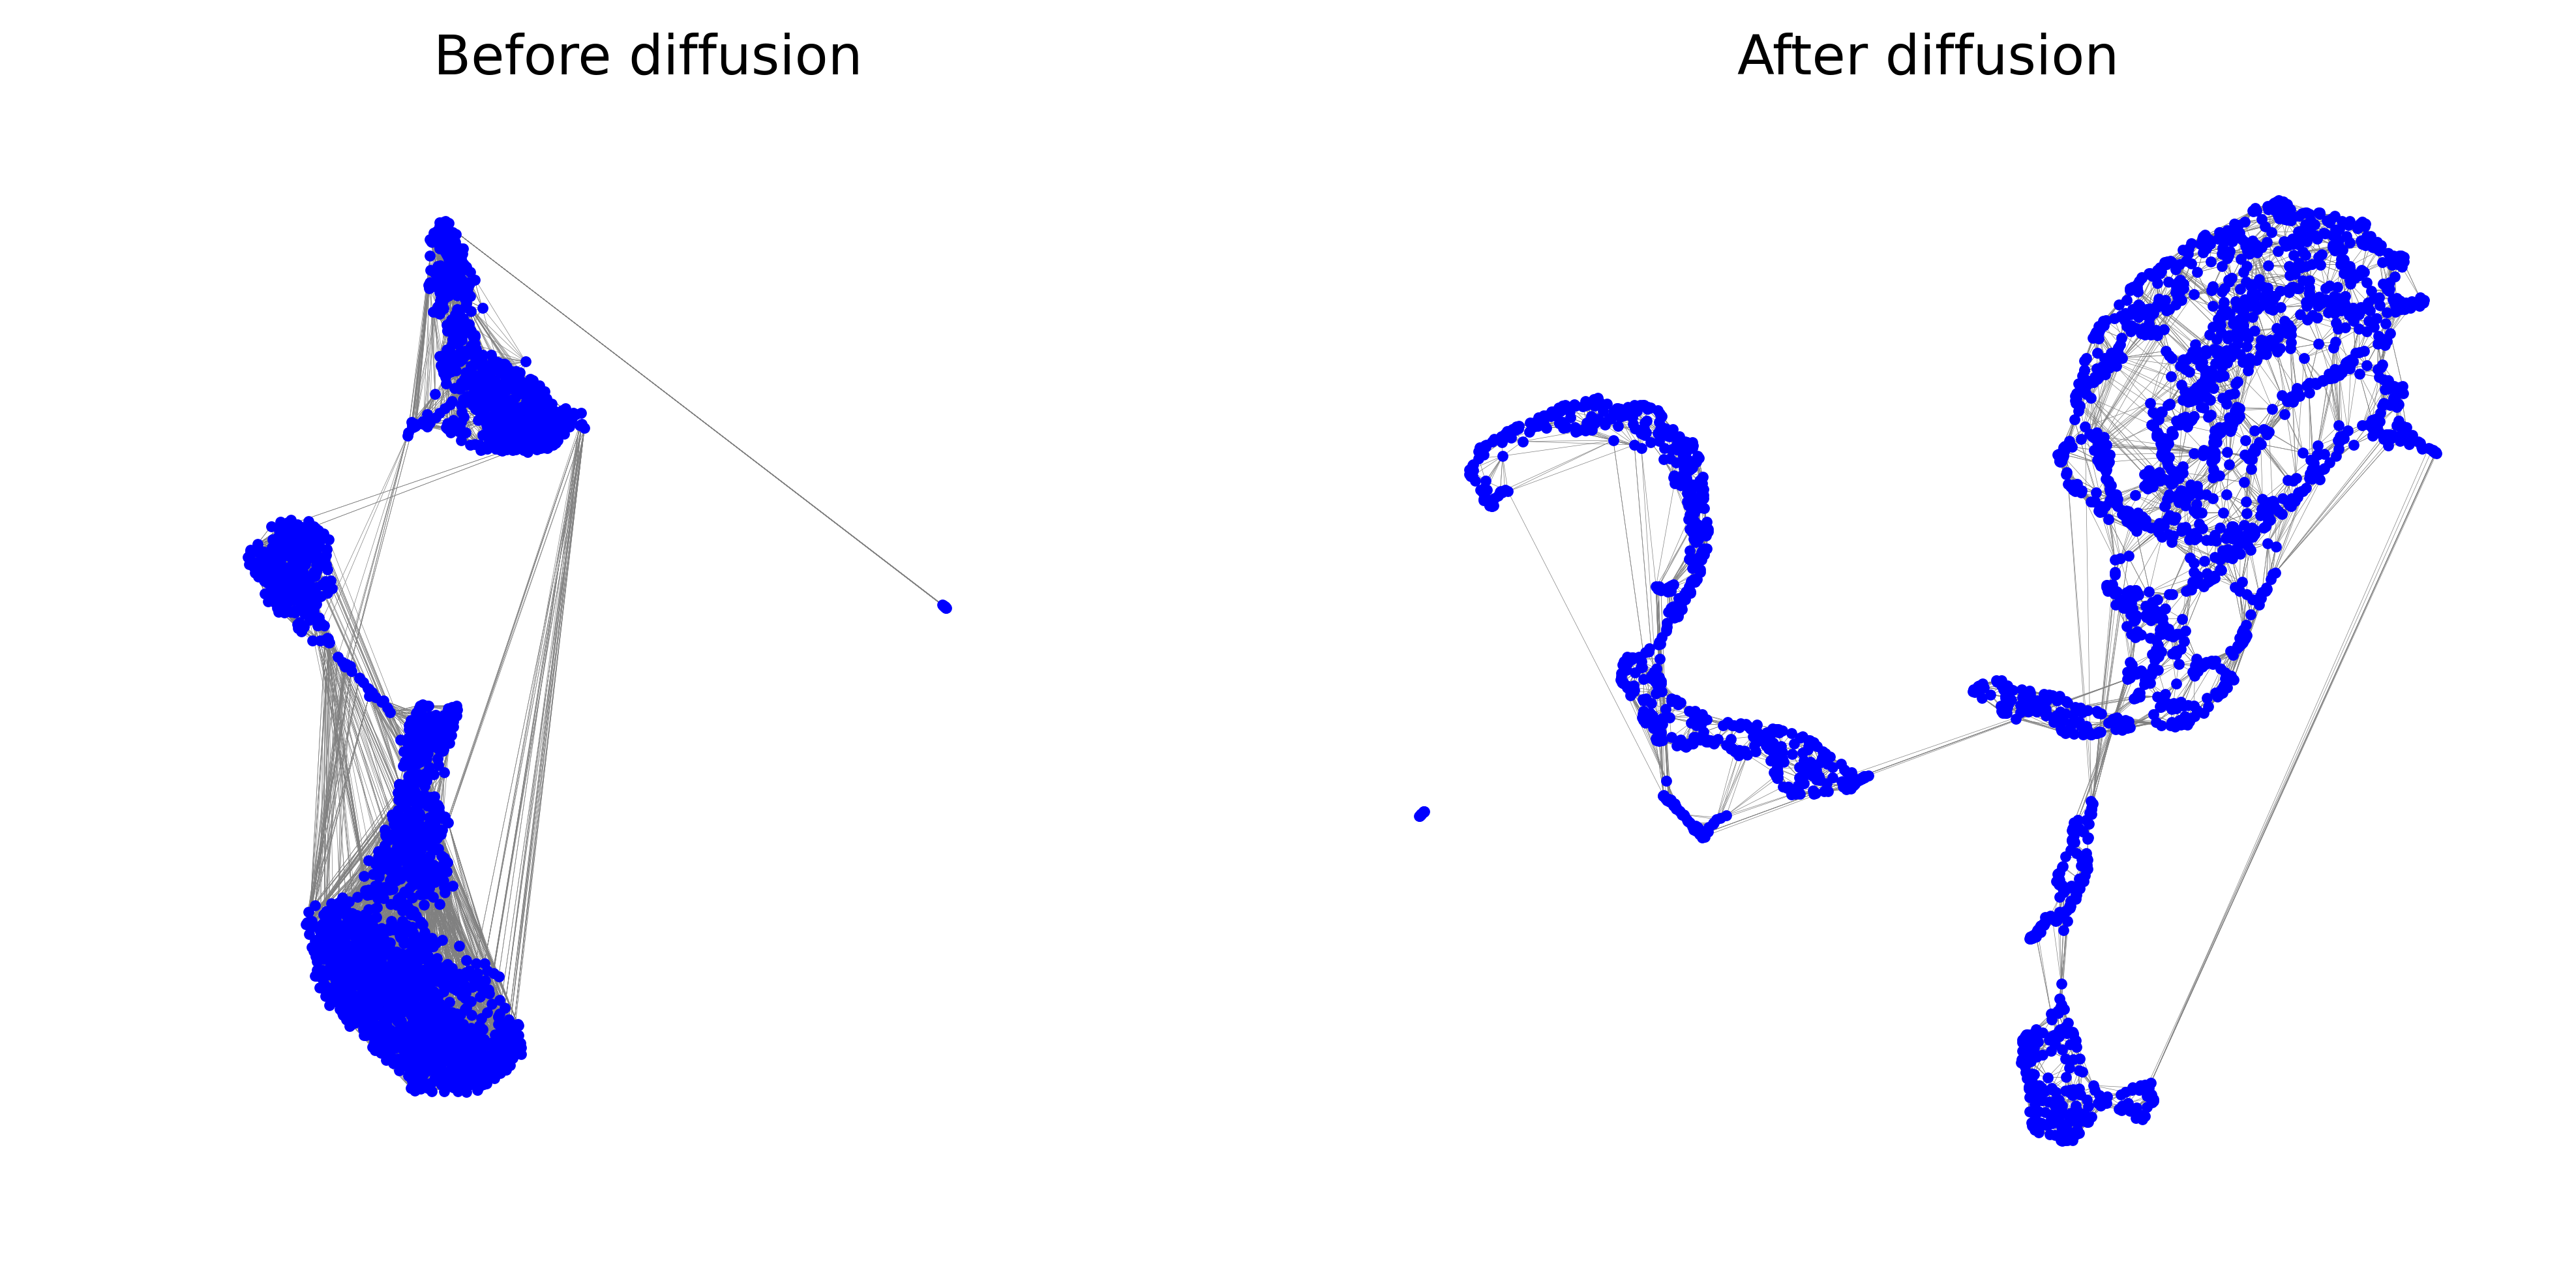

In [22]:
gnd_view(scdata, fig_size = (8,4), 
                   clusters=False, edges=True, 
                   edge_scale=0.1, node_scale=2, save_fig=None)

# umap_view(scdata, data='gae.output',clusters=False, edges=True, 
#           edge_scale=0.02, node_scale=0.5, save_fig=OUTPUT_PATH+'umap.png')

## Call cell-cell attentions

### Attention for scdata.graph

In [23]:
# build acdata.graph

scdata = build_graph(scdata, k=30, data_type="gae", graph_name='graph', self_edge = False, prune=True)

print("Total number of edges: ", scdata.graph.edge_index.shape[1])


Total number of edges:  79895


In [24]:
# Calculation attentions

scdata = call_attention(scdata, data_type="gae_output", use_graph="graph", distance_adjust=False)


In [25]:
#load attentions to edges of acdata.graph

scdata.graph.load_edge_attention(attention_type='adjusted_attention')


### Attention for graphs in diffusion process

In [26]:
scdata = build_gnd_graph(scdata, k=30, self_edge = False, prune=True)


In [27]:
scdata = call_gnd_attention(scdata, distance_adjust=False)


In [28]:
scdata.load_gnd_edge_attention(attention_type='adjusted_attention')


## Clustering

In [65]:
# Cell-cell attentions based clustering

scdata= clustering(scdata, use_graph="graph", resolution=0.3, rank_labels=True)

print("Total number of clusters: ", max(scdata.cluster)+1)
print(scdata.cluster)

#scdata.save(OUTPUT_PATH+"scdate_cluster.pickle")

Total number of clusters:  10
[0 5 5 ... 6 6 0]


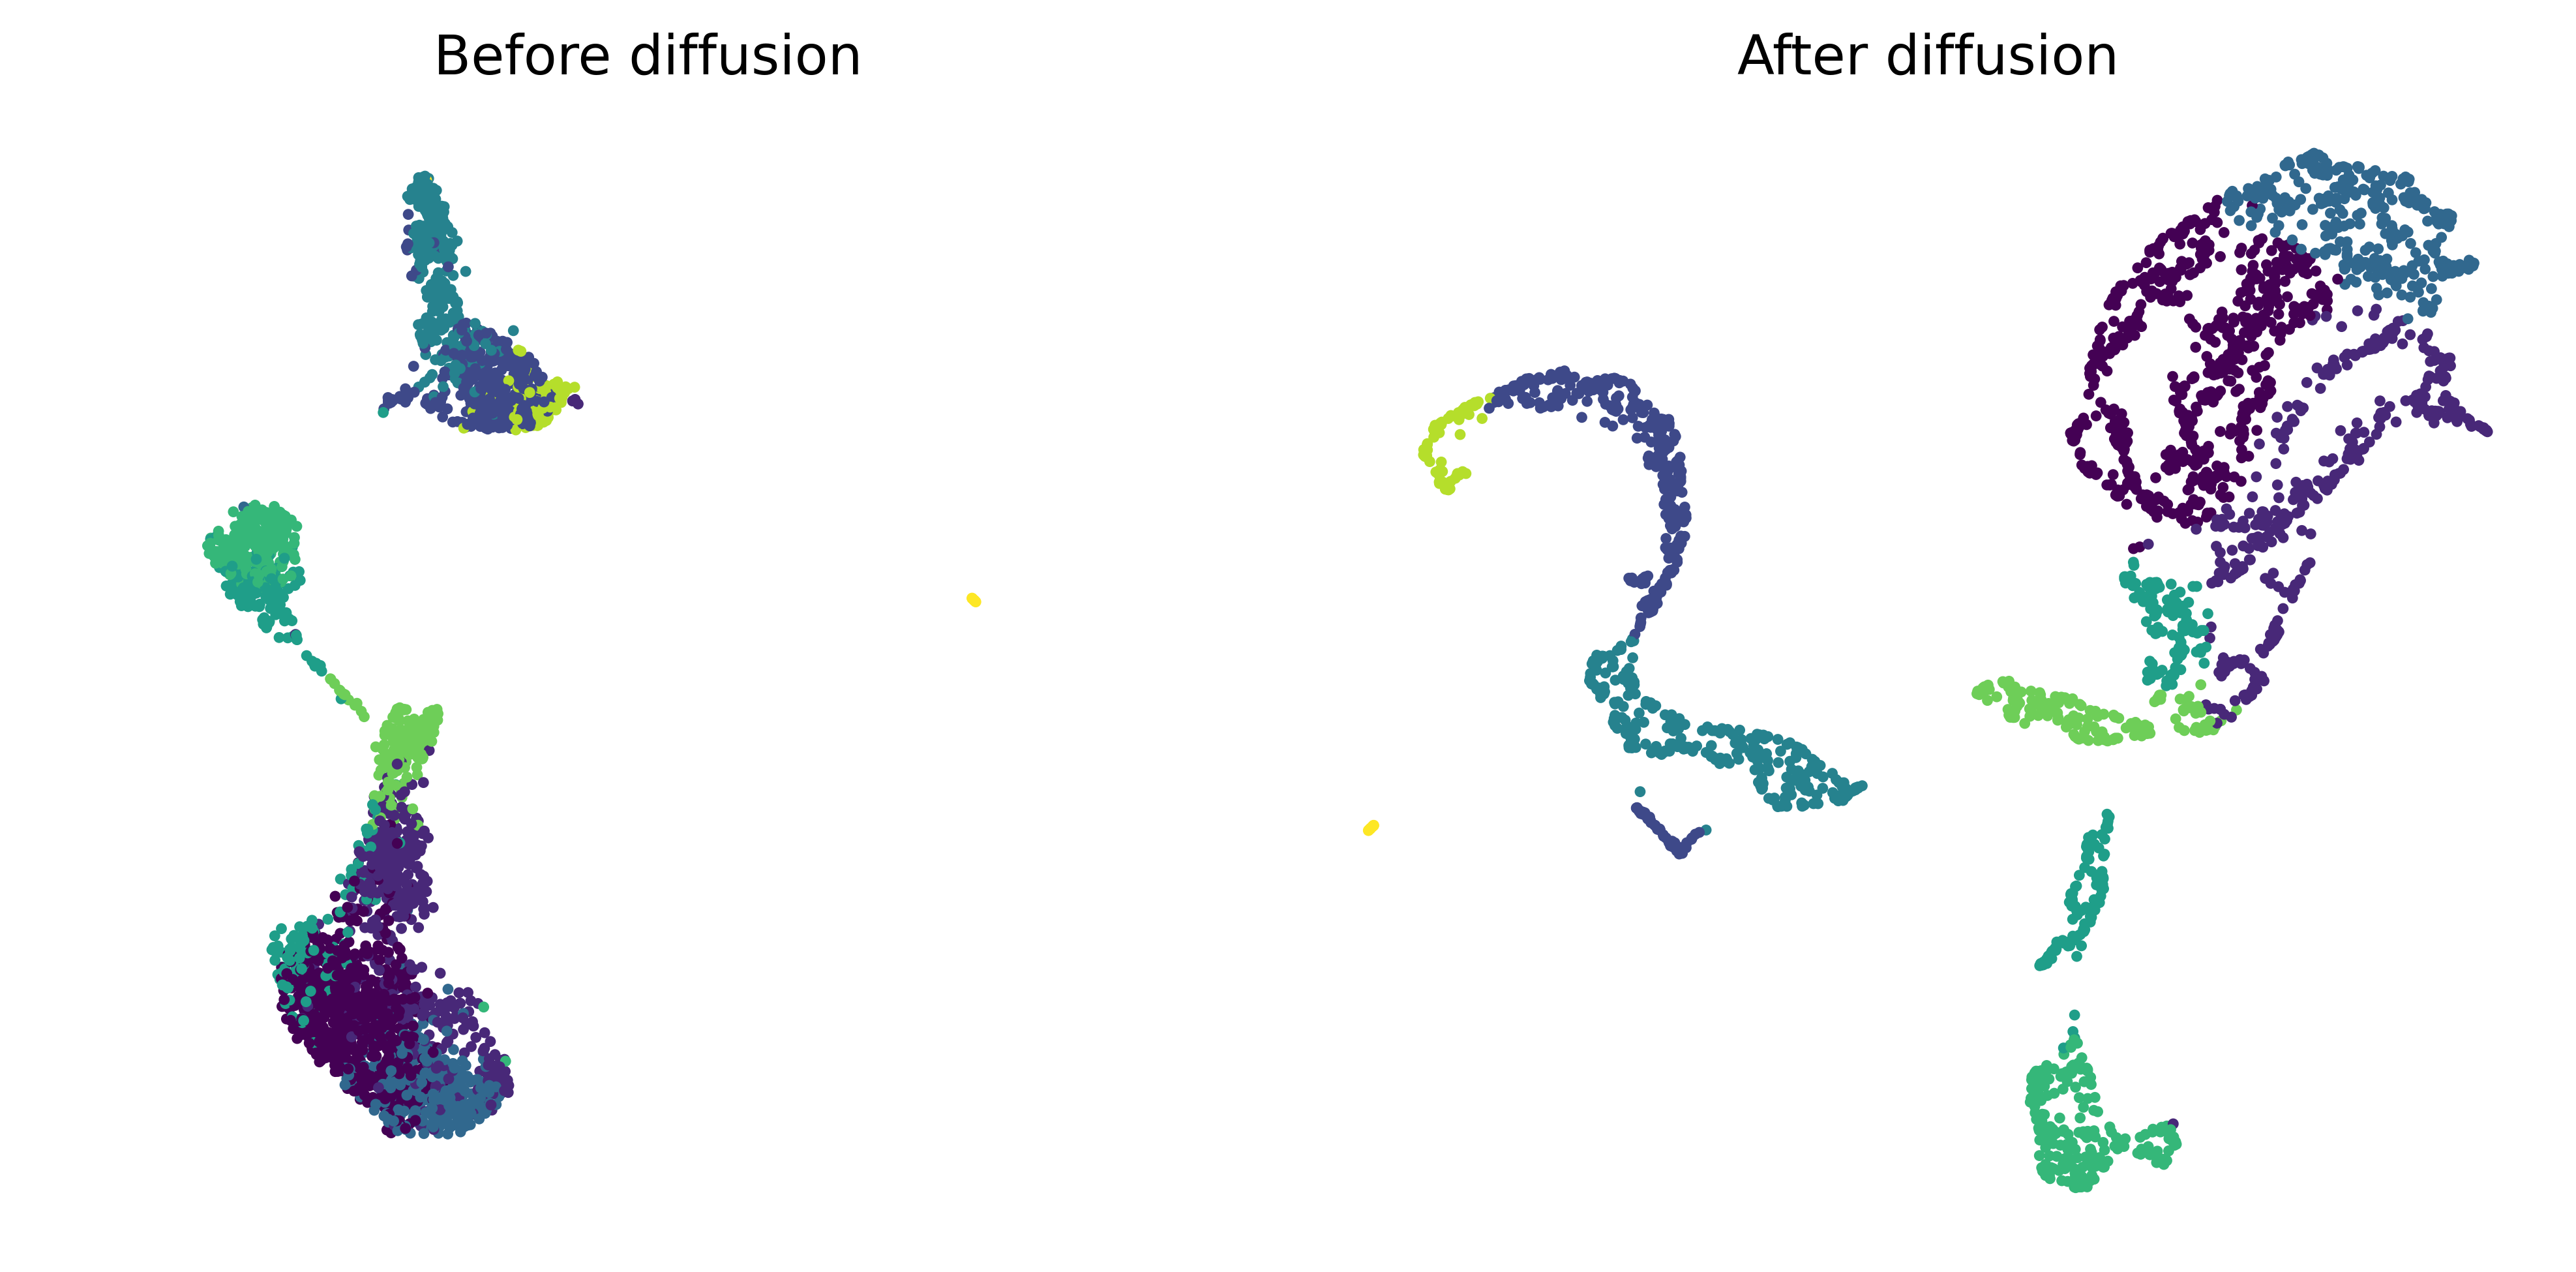

In [66]:
gnd_view(scdata, fig_size = (8,4), 
                   clusters=True, edges=False, 
                   edge_scale=0.1, node_scale=2, save_fig=None)

# umap_view(scdata, data='gae.output',clusters=True, edges=False, 
#           edge_scale=0.2, node_scale=1.5, save_fig=OUTPUT_PATH+'dif_figure_output.png')

In [74]:
# Record cluster information

scdata = record_cluster(scdata)


## Save scdata

In [30]:

scdata.save(OUTPUT_PATH+"scdata_cluster.pickle")


## Load scdata

In [31]:
scdata = SCData.load(OUTPUT_PATH+"scdata_cluster.pickle")

## Modularity Visualisation

In [142]:
# Clusters based modularity

modularity = call_modularity(scdata, use_graph="graph", edge_weight=True)
print(modularity)

0.5428347240921859


In [ ]:
Weighted_modularity = call_gnd_modularity(scdata)

In [ ]:
view_modularity(Weighted_modularity)

# Visualisation

In [70]:
scdata = umap_embedding(scdata, data = 'gae.gnd', 
                        umap_args = {'n_neighbors': 50,
                                     'min_dist': 0.8,
                                     'metric': 'correlation',
                                     'random_state': 2021})

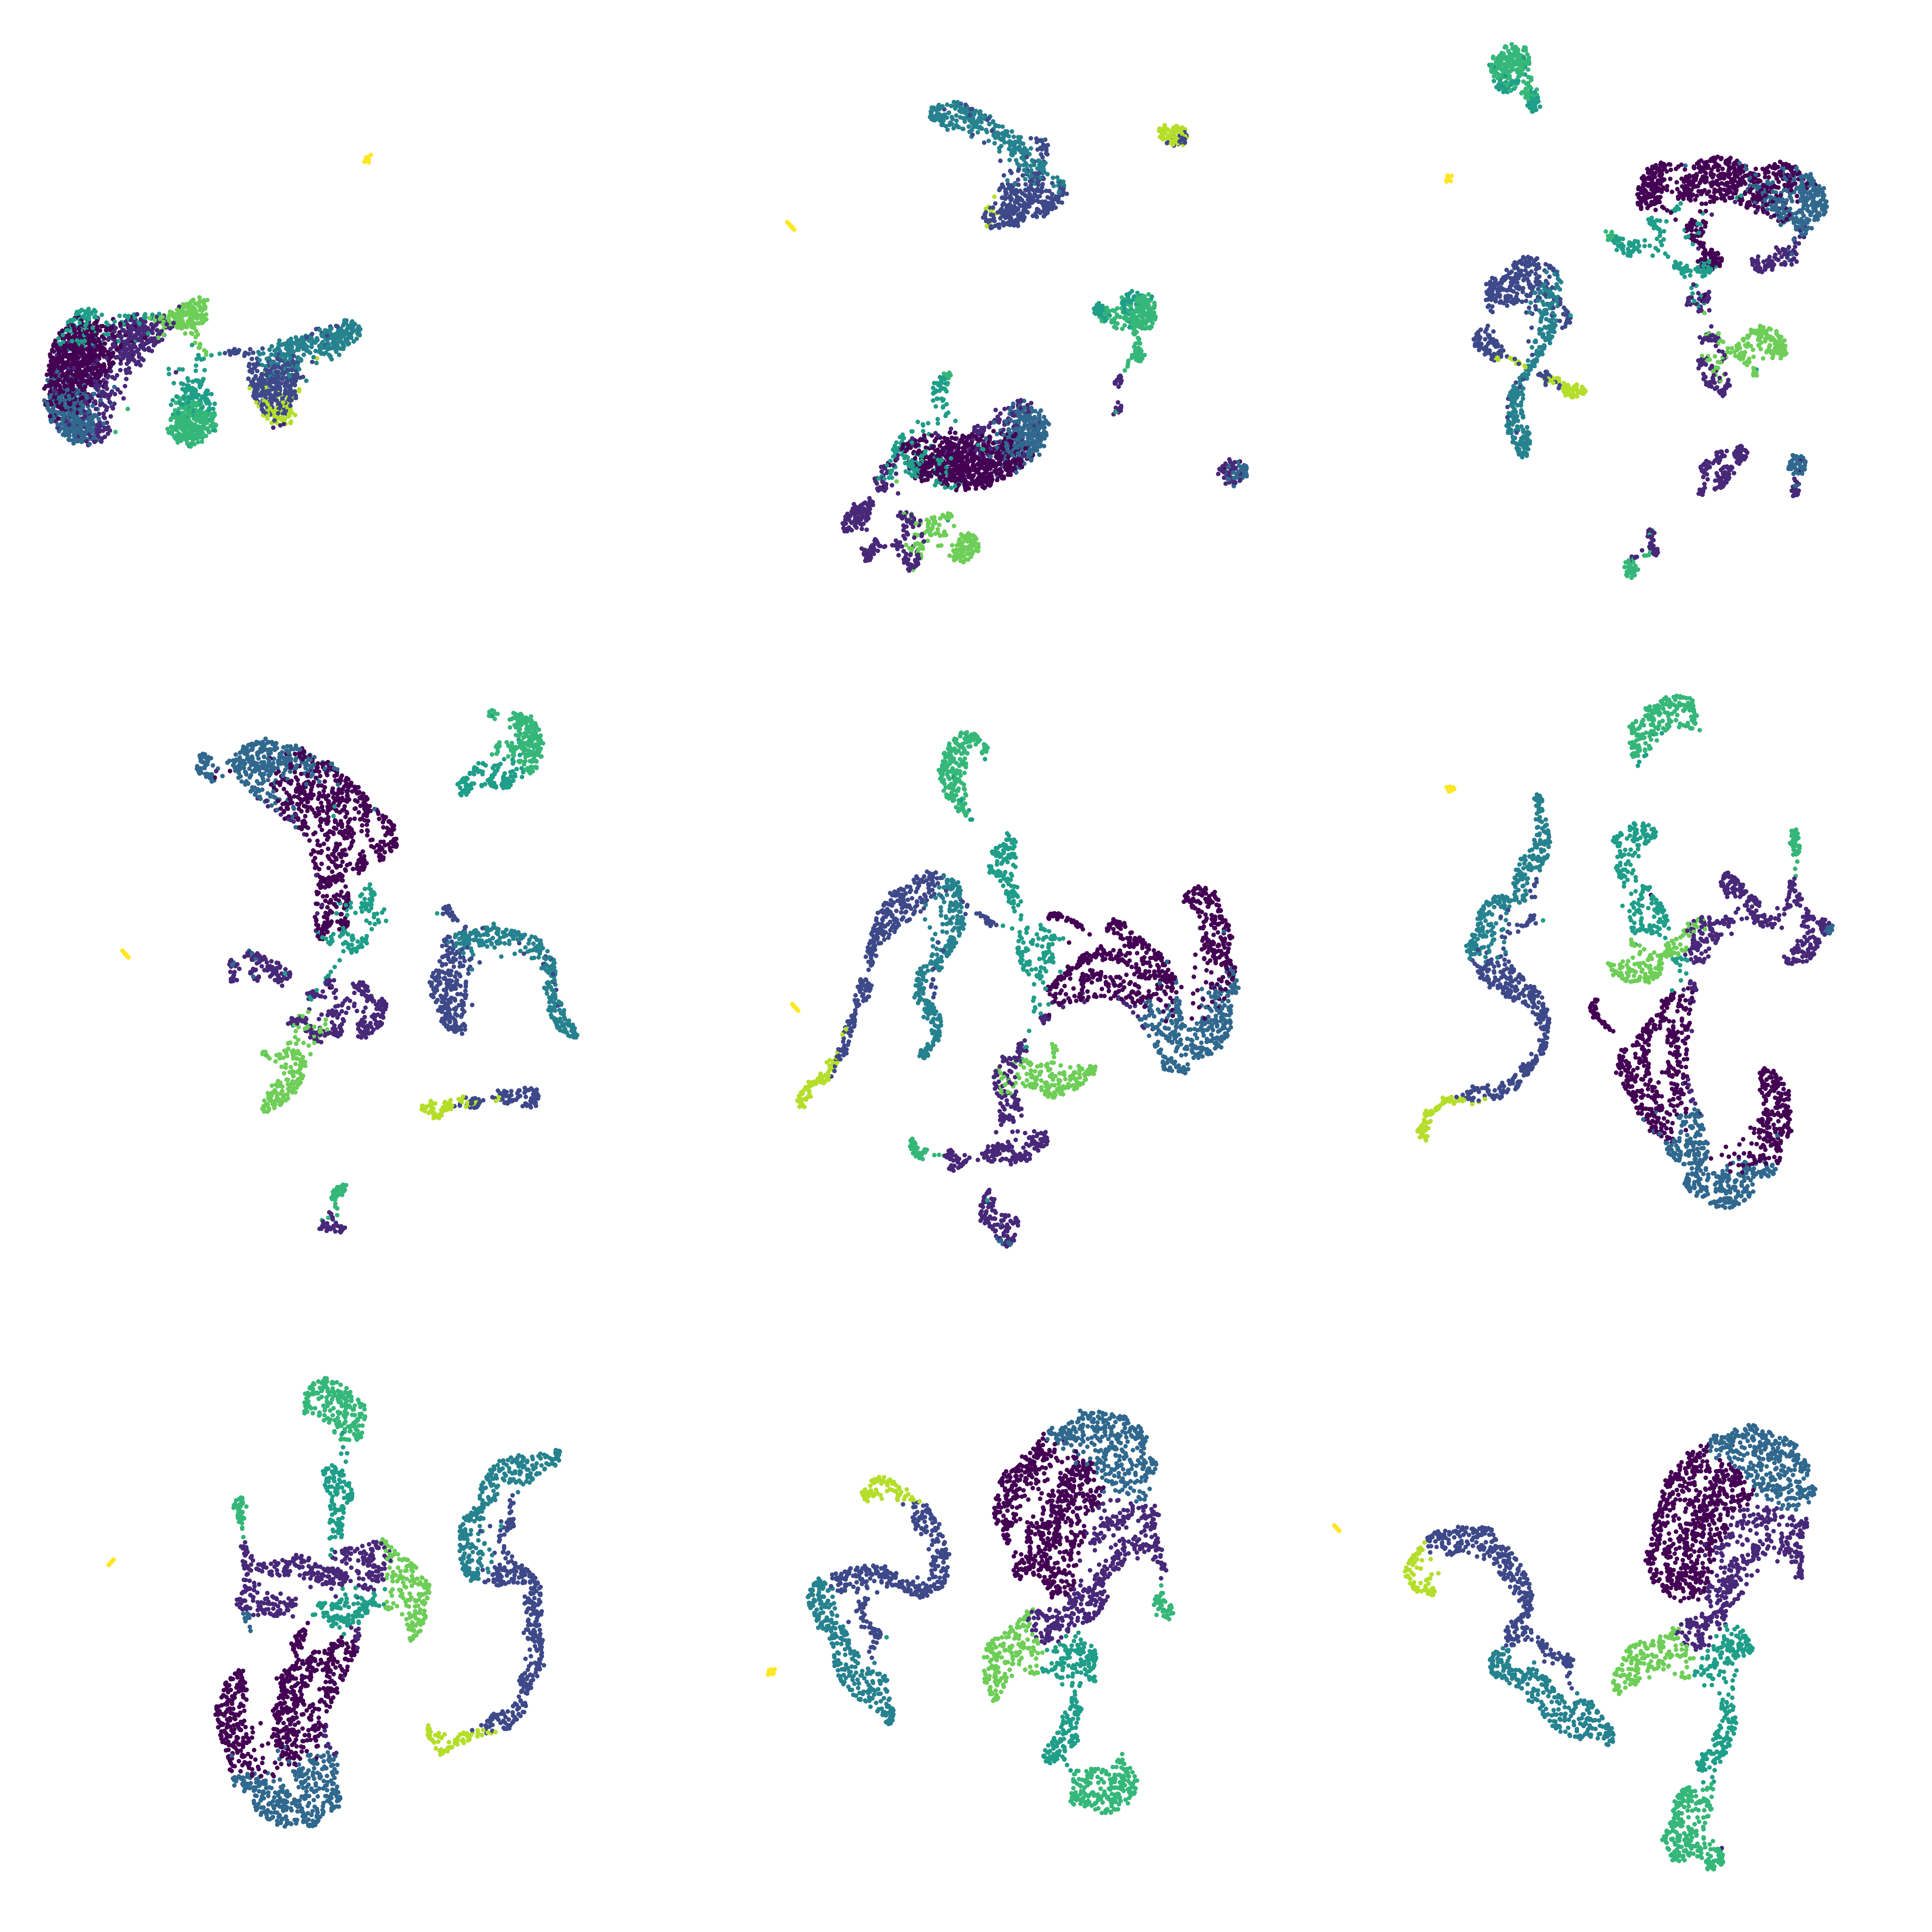

In [71]:
diffusion_view(scdata, layout = [3,3], fig_size = (12,12), 
                   clusters=True, edges=False, 
                   edge_scale=0.0, node_scale=1, title=False, save_fig=OUTPUT_PATH+'diffusion.png')